In [33]:
# Load python packages
import cv2
import numpy as np
import scipy 
import scipy.linalg 
from scipy.misc import imread
#import pykitti
import glob
import yaml
import csv

# Inline plotting or interactive? 
# Attention:
# 1. Need restart kernel
# 2. Need to declare before import matplotlib
%matplotlib inline
#%matplotlib notebook

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


#-------------
# Dataset location
#-------------
# Change this to the directory where you store EuRoC MAV data
basedir = '/Users/jinchengli/study/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/'

## Tile-based KLT tracker

image size (w, h):  752 480
Tile (y,x): 0 0
New corners detected: 35
Total corners (35, 1, 2)
Tile (y,x): 0 100
New corners detected: 50
Total corners (85, 1, 2)
Tile (y,x): 0 200
New corners detected: 50
Total corners (135, 1, 2)
Tile (y,x): 0 300
New corners detected: 50
Total corners (185, 1, 2)
Tile (y,x): 0 400
New corners detected: 50
Total corners (235, 1, 2)
Tile (y,x): 0 500
New corners detected: 50
Total corners (285, 1, 2)
Tile (y,x): 0 600
New corners detected: 45
Total corners (330, 1, 2)
Tile (y,x): 0 700
New corners detected: 9
Total corners (339, 1, 2)
Tile (y,x): 100 0
New corners detected: 46
Total corners (385, 1, 2)
Tile (y,x): 100 100
New corners detected: 50
Total corners (435, 1, 2)
Tile (y,x): 100 200
New corners detected: 50
Total corners (485, 1, 2)
Tile (y,x): 100 300
New corners detected: 50
Total corners (535, 1, 2)
Tile (y,x): 100 400
New corners detected: 50
Total corners (585, 1, 2)
Tile (y,x): 100 500
New corners detected: 50
Total corners (635, 1, 2)
T

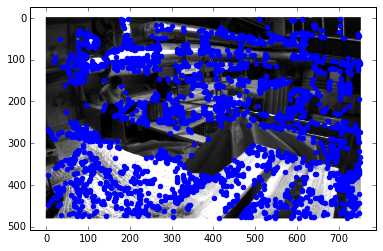

Frame  1 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1910, 4)
feature_list.shape:  (1910, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [45 57 55 31 65 39 51 15 17 69 59 11  1 27 35  9  3 49  7 29 61  5 25 37 13
 33 67 41 21 47 53 63 23 19 43]
[[ 0.        ]
 [ 0.99514544]
 [ 0.        ]
 [-0.37770331]] min_err =  0.00783401 inliers =  35   50.0 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [37 12 30 20 52 45 48 10  8 26 71 50 97 36 31 74 16  7 89 75 61 65  3 84 64
 83 47 29 85 58 15 63 42 88 72 76 55 34 86 62 98 94 67 18 28 13  2 77 66 99
  6 44 79 69 93 80 21  4 38 59 24 87  0 51  9 35 14 40 70 91 19 17 39 49 92
 68 46 54 90 25 11 23 43  5 81  1 82 56 73 32 41 78 22 57 95 33 60 53 96]
[[ 1.0

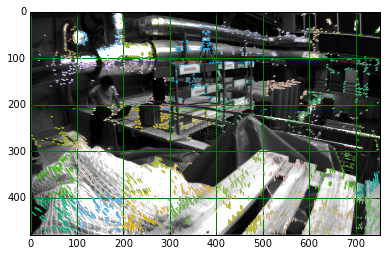

Frame  2 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1906, 4)
feature_list.shape:  (1906, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [40 62 46  6 50 34  0 42 14 25 10 13 19 18 26 47 55  4 12 22 30 36 58  3 69
 20 32 27  9 52 15 54 60 68  2 16  5 28 66 24 48  8 56 38 64 44]
[[ 1.00207293]
 [ 0.99831522]
 [-1.74684119]
 [-4.33168983]] min_err =  0.0103188 inliers =  46   65.71428571428571 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [96 45 28  8 86  4 94 52 82 10 25 65 81 12 95 72 44 70 33 59 76  3 31  9  1
 60 79 90 48 57 83 27 78 29 37 58 36 62 53 98 64 39 92 43 13 49 17 84 15 21
 40 38 66 18 22 61 46 97  7 55 32 47 20 88 24 42 75 23  5 30 74 99 54 19 67
 68 87 91 26 34 35 56 69 11 73  2 8

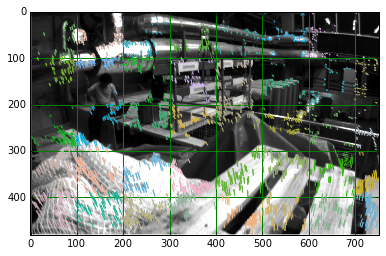

In [2]:
# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
## Interactive mode - show image of every frame interactively.
INTERACTIVE = True


# Tile size
tile_size = 100

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 3, 1)

#-------------
# Main(): Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    plt.imshow(cam0,cmap='gray')

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []

    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

#        # Draw filtered feature points and associated OF
#        for idx in range(feature_list.shape[0]):
#            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
#                            [feature_list[idx,1], feature_list[idx,3]],
#                            linestyle='-', color='plum')

#        # Draw old feature points
#        #plt.scatter(good_old[:,0], good_old[:,1], marker='^', c='g')
#        # Draw new feature points
#        #plt.scatter(good_new[:,0], good_new[:,1], marker='o', c='r')
#        # Draw optical flow
#        for idx in range(good_old.shape[0]):
#            plt.plot([good_old[idx,0], good_new[idx,0]], 
#                            [good_old[idx,1], good_new[idx,1]],
#                            linestyle='-', color='b')

        # Find affine parameters sx,sy,tx,ty for each grid
        of.OF_TileAffineSolver(cam0, tile_size, feature_list)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)



    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'_of.png')
    # Show the OF tracking image
    if INTERACTIVE:
        plt.show()
    
        ## Use opencv to show image
        #cv2.imshow('cam0',cam0)
        #k = cv2.waitKey(-1)
        #cv2.destroyAllWindows()

## Frame-level KLT tracker

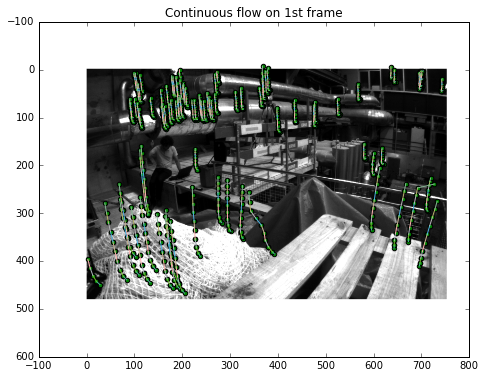

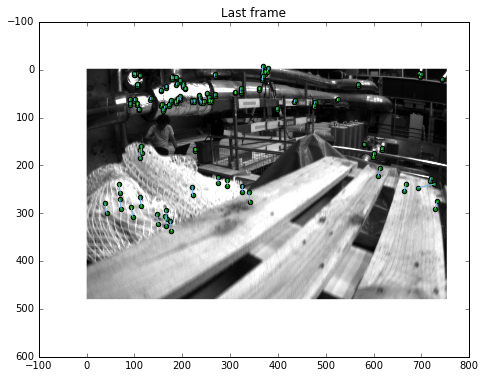

In [3]:
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 10, 1)

#-------------
# Processing cam
#-------------
dpi = 80

# Read 1st frame
cam0 = cv2.imread(cam0_img_list[0], cv2.IMREAD_GRAYSCALE)

# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
#plt.autoscale(tight=True)


# Show the gray img from camera 0
plt.imshow(cam0, cmap='gray')
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        #plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
plt.show()

# Draw last frame
plt.figure(figsize=figsize)
#plt.axis('off')
plt.imshow(cam0, cmap='gray')
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()
    

## Camera distortion correction

Use page: https://hackaday.io/project/12384-autofan-automated-control-of-air-flow/log/41862-correcting-for-lens-distortions

cam0 intrinsics = 
 [[ 458.654    0.     367.215]
 [   0.     457.296  248.375]
 [   0.       0.       1.   ]]
cam0 distortion_coeffs = 
 [ -2.83408110e-01   7.39590700e-02   1.93590000e-04   1.76187114e-05
   0.00000000e+00]
cam0 T_BS (MAV body to camera sensor) = 
 [[ 0.01486554 -0.99988093  0.0041403  -0.02164015]
 [ 0.99955725  0.01496721  0.02571553 -0.06467699]
 [-0.02577444  0.00375619  0.99966073  0.00981073]
 [ 0.          0.          0.          1.        ]]


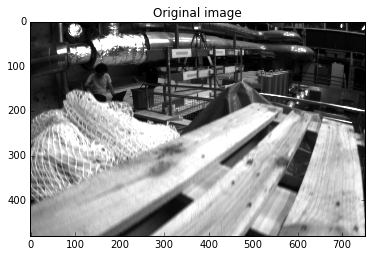

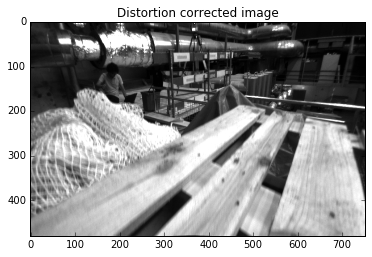

(480, 752) (480, 752) (480, 752)


In [4]:
import yaml

# Load cam0 sensor config
with open(basedir+'mav0/cam0/sensor.yaml') as fp:
    cam0_yaml = yaml.load(fp)
#print(cam0_yaml)
fp.close()

# K - intrinsics
K_params = cam0_yaml['intrinsics']
K = np.array([
    [K_params[0], 0., K_params[2]],
    [0., K_params[1], K_params[3]],
    [0., 0., 1.]
]) 
print("cam0 intrinsics = \n", K)

# D - distortion coefficients
D_params = cam0_yaml['distortion_coefficients']
D = np.hstack([D_params[:], 0.])
print("cam0 distortion_coeffs = \n", D)

w, h = cam0_yaml['resolution']

# T_BS - [R t] from MAV body coordinates to sensor (cam0) coordinates
T_BS = cam0_yaml['T_BS']['data']
T_BS_cols = cam0_yaml['T_BS']['cols']
T_BS_rows = cam0_yaml['T_BS']['rows']
T_BS = np.array(T_BS).reshape(T_BS_rows, T_BS_cols)
print("cam0 T_BS (MAV body to camera sensor) = \n", T_BS)

# Generate new camera matrix from parameters
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 0)

# Generate look-up tables for remapping the camera image
mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, newcameramatrix, (w, h), 5)

# Remap the original image to a new image
#new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR)
new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Display old and new image

plt.imshow(cam0, cmap='gray')
plt.title('Original image')
plt.show()
plt.imshow(new_cam0, cmap='gray')
plt.title('Distortion corrected image')
plt.show()

print(mapx.shape, mapy.shape,cam0.shape)

## Frame-level KLT tracker on undistorted image

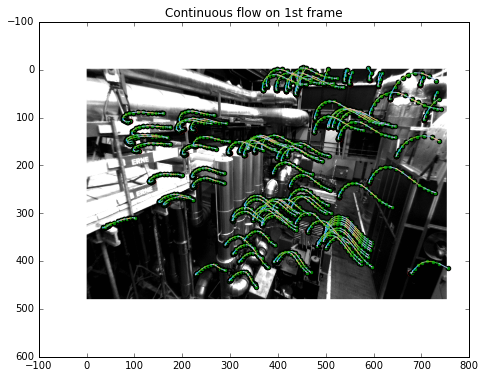

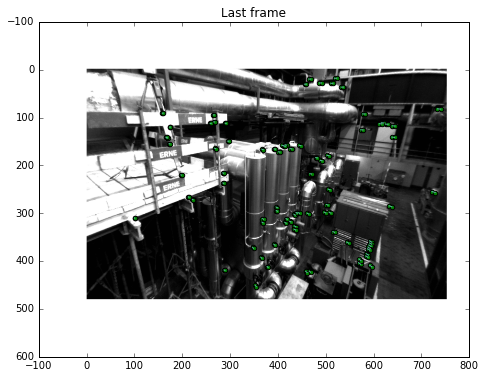

In [49]:
#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(1050, 1070, 1)

#-------------
# Processing cam
#-------------
dpi = 80

# Read 1st frame
cam0_ori = cv2.imread(cam0_img_list[frame_range[0]], cv2.IMREAD_GRAYSCALE)
# Image undistortion
cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
#plt.autoscale(tight=True)


# Show the gray img from camera 0
plt.imshow(cam0, cmap='gray')
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0_ori = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    # Image undistortion
    cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==frame_range[0]:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
plt.show()

# Draw last frame
plt.figure(figsize=figsize)
plt.imshow(cam0, cmap='gray')
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()

## Pose estimation using 8-pt algorithm

### Utility functions

In [ ]:
def plot_epipolar_lines_on_images(points1, points2, im1, im2, f):
    '''
    PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
    draws the epipolar lines on the images
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
        im1 - a HxW(xC) matrix that contains pixel values from the first image 
        im2 - a HxW(xC) matrix that contains pixel values from the second image 
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        Nothing; instead, plots the two images with the matching points and
        their corresponding epipolar lines. See Figure 1 within the problem set
        handout for an example
    '''
    # epipolar line in second image: l' = f x
    epi_l_p = np.matmul(f, points1.t).t
    # draw points onto image2
    plt.subplot(121)
    plt.plot(points2[:,0], points2[:,1], 'ro')
    
    # draw epipolar lines on image2
    num_lines = epi_l_p.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l_p[i]
        x = np.array([0., 512.])
        y = -(a*x + c)/b
        plt.plot(x,y,color='b')
        # plot calculated corresponding points
        plt.plot(points2[i,0], -(a*points2[i,0]+c)/b, 'go')
        
    plt.imshow(im2, extent=[0, 512, 512, 0], cmap='gray')
    
    # epipolar line in first image: l = f^t x'
    epi_l = np.matmul(F.T, points2.T).T
    # Draw points onto image1
    plt.subplot(122)
    plt.plot(points1[:,0], points1[:,1], 'ro')

    # Draw epipolar lines on image1
    num_lines = epi_l.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l[i]
        x = np.array([0., 512.])
        y = -(a*x + c)/b
        plt.plot(x,y,color='b')
        # Plot calculated corresponding points
        plt.plot(points1[i,0], -(a*points1[i,0]+c)/b, 'go')

    plt.imshow(im1, extent=[0, 512, 512, 0], cmap='gray')
    plt.show()


def compute_distance_to_epipolar_lines(points1, points2, F):
    '''
    COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
    points to their corresponding epipolar lines
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        average_distance - the average distance of each point to the epipolar line
    ''' 
    # Epipolar line in image 1 from F and points2
    epi_l= np.matmul(F.T, points2.T).T
    # line ax+by+c=0
    a = epi_l[:,0]
    b = epi_l[:,1]
    c = epi_l[:,2]
    # Points to be calculated distance
    x0 = points1[:,0]
    y0 = points1[:,1]
    # Distance calculated
    d = np.abs(a*x0+b*y0+c)/np.sqrt(a**2+b**2)

    return np.mean(d)

def lls_eight_point_alg(points1, points2):
    '''
    LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
    linear least squares eight point algorithm
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
    
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    Please see lecture notes and slides to see how the linear least squares eight
    point algorithm works
    '''
    x1 = points1[:,0].reshape(-1,1)
    y1 = points1[:,1].reshape(-1,1)
    x1p = points2[:,0].reshape(-1,1)
    y1p = points2[:,1].reshape(-1,1)
    
    # Come up with Af=0
    A = np.hstack([x1p*x1, x1p*y1, x1p, y1p*x1, y1p*y1, y1p, x1, y1,                    points1[:,2].reshape(-1,1)])
    # Using SVD to find least-square solution of f 
    U,s,V_transpose = np.linalg.svd(A)
    # f is the last column of V
    f = V_transpose[-1,:]
    F = f.reshape(3,3)/f[-1]
    
    # Using SVD again to decompose F
    U1,s1,V1_transpose = np.linalg.svd(F)
    # Force rank 2
    D = np.zeros([3,3])
    D[0,0]=s1[0]
    D[1,1]=s1[1]
    # Get F'
    Fp = np.matmul(U1, np.matmul(D, V1_transpose))
    return Fp


def normalized_eight_point_alg(points1, points2):
    '''
    NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
    using the normalized eight point algorithm
    Arguments:
        points1 - N points in the first image that match with points2
        points2 - N points in the second image that match with points1
    
        Both points1 and points2 are from the get_data_from_txt_file() method
    Returns:
        F - the fundamental matrix such that (points2)^T * F * points1 = 0
    Please see lecture notes and slides to see how the normalized eight
    point algorithm works
    '''
    # Find mean of x,y co-ordinates
    ave_pts1 = np.mean(points1,axis=0)
    ave_pts2 = np.mean(points2,axis=0)
    # Calc mean distance to centroid points
    tmp1 = points1 - ave_pts1
    dist1 = np.mean(np.sqrt((tmp1[:,0])**2 + (tmp1[:,1])**2))
    scale1 = 2./dist1
    tmp2 = points2 - ave_pts2
    dist2 = np.mean(np.sqrt((tmp2[:,0])**2 + (tmp2[:,1])**2))
    scale2 = 2./dist2
    # T matrices
    T1 = np.array([[scale1, 0., 0.], [0., scale1, 0.],
            [-scale1*ave_pts1[0], -scale1*ave_pts1[1], 1.]])
    T2 = np.array([[scale2, 0., 0.], [0., scale2, 0.],
            [-scale2*ave_pts2[0], -scale2*ave_pts2[1], 1.]])
    # normalized points
    norm_pts1 = np.matmul(points1, T1)
    norm_pts2 = np.matmul(points2, T2)

    # Now run the linear least squares eight point algorithm
    F_lls = lls_eight_point_alg(norm_pts1, norm_pts2)
    
    # Un-normalize
    F = np.matmul(T2, np.matmul(F_lls, T1.T))
    F = F/F[2,2]

    return F


### Experiment

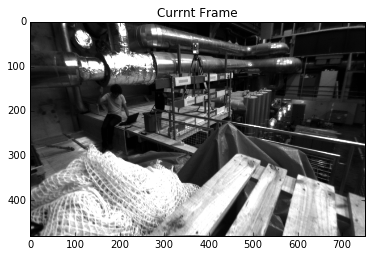

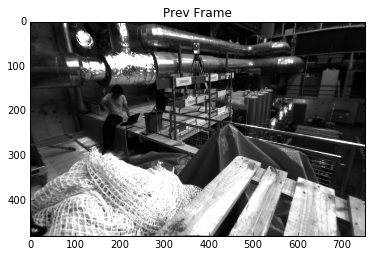

((100, 2), (100, 2))

In [43]:
tmp_c = imread(cam0_img_list[fr])
frame_c = cv2.remap(tmp_c, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
plt.imshow(frame_c, cmap='gray')
plt.title("Currnt Frame")
plt.show()
tmp_p = imread(cam0_img_list[fr-1])
frame_p = cv2.remap(tmp_p, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
plt.imshow(frame_p, cmap='gray')
plt.title("Prev Frame")
plt.show()
good_old.shape, good_new.shape

## Trajectory drawing

Useful page: https://matplotlib.org/examples/mplot3d/lines3d_demo.html


### Load trajectory from dataset

In [13]:

def q2R(w, x, y, z):
    """
    Transform a unit quaternion into its corresponding rotation matrix (to
    be applied on the right side).
      
    :returns: transform matrix
    :rtype: numpy array
  
    """
    xx2 = 2 * x * x
    yy2 = 2 * y * y
    zz2 = 2 * z * z
    xy2 = 2 * x * y
    wz2 = 2 * w * z
    zx2 = 2 * z * x
    wy2 = 2 * w * y
    yz2 = 2 * y * z
    wx2 = 2 * w * x
      
    R = np.empty((3, 3), float)
    R[0,0] = 1. - yy2 - zz2
    R[0,1] = xy2 - wz2
    R[0,2] = zx2 + wy2
    R[1,0] = xy2 + wz2
    R[1,1] = 1. - xx2 - zz2
    R[1,2] = yz2 - wx2
    R[2,0] = zx2 - wy2
    R[2,1] = yz2 + wx2
    R[2,2] = 1. - xx2 - yy2
      
    return R
    
# Load leica0 sensor config - position measurement mounted on IMU (ADIS16448)
with open(basedir+'mav0/leica0/sensor.yaml') as fp:
    leica0_yaml = yaml.load(fp)
fp.close()
# T_BL - [R t] from MAV body coordinates to sensor (leica0) coordinates
#   As it is rigidly mounted on IMU, there's only translation from B.
T_BL = leica0_yaml['T_BS']['data']
T_BL_cols = leica0_yaml['T_BS']['cols']
T_BL_rows = leica0_yaml['T_BS']['rows']
T_BL = np.array(T_BL,dtype='float').reshape(T_BL_rows, T_BL_cols)
print("leica0 T_BL (MAV body to leica0 prism marker) = \n", T_BL)

# Trajectory points
T_WL_x = []
T_WL_y = []
T_WL_z = []

# Load ground truth data of leica0 prism marker
CSV_READ_N_LINES = 36000
with open(basedir+'mav0/state_groundtruth_estimate0/data.csv', newline='') as fp:
    reader = csv.reader(fp)
    # Skip first line, specifying column contents category
    next(reader)
    for i,row in enumerate(reader):
        tx, ty, tz, qw, qx, qy, qz = np.array(row[1:8]).astype('float')
        #print(tx, ty, tz, qw, qx, qy, qz)
        R = q2R(qw, qx, qy, qz)
        t = np.array([tx,ty,tz]).reshape(3,1)
        T_WL = np.hstack([R, t])
        #print("T_WL (world to leica0) = \n", T_WL)
        
        T_WL_x.append(tx)
        T_WL_y.append(ty)
        T_WL_z.append(tz)
        
        if i > CSV_READ_N_LINES:
            break
        
fp.close


leica0 T_BL (MAV body to leica0 prism marker) = 
 [[ 1.         0.         0.         0.0748903]
 [ 0.         1.         0.        -0.0184772]
 [ 0.         0.         1.        -0.120209 ]
 [ 0.         0.         0.         1.       ]]


<function TextIOWrapper.close>

### Draw the trajectory

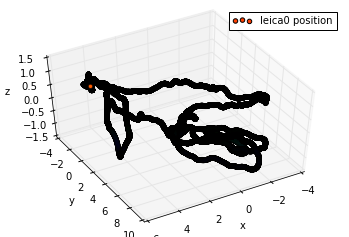

In [14]:

# Draw the trajectory 
matplotlib.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(T_WL_x, T_WL_y, T_WL_z, c=T_WL_z, label='leica0 position')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Top-down view?
#ax.view_init(azim=270, elev=90)
#
ax.view_init(azim=60, elev=50)

plt.show()
